# Design the bound states, sampling backbones for looping while maintaining sequence realism

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties
running on node: dig119


### Set working directory to the root of the crispy_shifty repo
TODO set to projects dir

In [2]:
os.chdir("/home/pleung/projects/crispy_shifty")
# os.chdir("/projects/crispy_shifty")

### One-state design the helix-bound states
TODO

In [3]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "00_design_bound_states"
design_list_file = os.path.join(
    os.getcwd(), "scaffolds/02_make_bound_states/bound_states.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.design.one_state_design_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="5G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/run.sh


In [4]:
!sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/run.sh

Submitted batch job 1307537


### Collect scorefiles of designed bound states and concatenate
TODO change to projects dir

In [3]:
sys.path.insert(0, "~/projects/crispy_shifty")  # TODO
from crispy_shifty.utils.io import collect_score_file

simulation_name = "00_design_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


https://docs.anaconda.com/anaconda/install



### Load resulting concatenated scorefile
TODO change to projects dir

In [4]:
sys.path.insert(0, "~/projects/crispy_shifty")  # TODO
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

  0%|          | 0/1670 [00:00<?, ?it/s]

### Setup for plotting

In [5]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration

In [6]:
len(scores_df)  #
scores_df.columns

Index(['bb_clash', 'best_average_DAN_plddts', 'best_average_plddts',
       'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent',
       'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'docked_helix',
       'dslf_fa13', 'exposed_hydrophobics_parent', 'fa_atr', 'fa_dun',
       'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'fa_elec',
       'fa_intra_atr_xover4', 'fa_intra_elec', 'fa_intra_rep',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'geometry_parent', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc',
       'hbond_sr_bb', 'holes_all_parent', 'holes_core_parent', 'hxl_tors',
       'lk_ball', 'lk_ball_bridge', 'lk_ball_bridge_uncpl', 'lk_ball_iso',
       'lk_ball_wtd', 'loop_dist', 'mismatch_probability_parent', 'omega',
       'p_aa_pp', 'packstat_parent', 'parent', 'parent_length', 'path_in',
       'pdb', 'pivot_helix', 'pre_break_helix', 'pro_close', 'rama_prepro',
       'ref', 'res_type_constraint', 'sap_parent', 'sc_AcB', 'sc_AnAc',
       

TODO: remember to use `df.convert_dtypes`

In [17]:
scores_df["time"] = scores_df.time.astype(float) / 60
scores_df["bb_clash"] = scores_df.bb_clash.astype(float)
scores_df["trimmed_length"] = scores_df.trimmed_length.astype(int)

TODO: check which ones failed

In [7]:
i = 0
for thing in set(scores_df.parent.values):
    if "_DHR" in thing:
        i += 1
print(i)
print(set(scores_df.parent.values))

20
{'X14_3_14_1_ct3_fe', 'X12_3_10_2_ct10_ff', 'JHR_bd4_01954', 'X23_2_15_3_ct5_fe', 'JHR_bd1_1594', 'JHR_bd1_555', 'X14_2_10_1_ct25_fa', 'X18_4_22_4_ct0_ff', 'JHR_bd5_17454', 'DHR80', 'DHR7', 'JHR_bd1_133', 'DHR52', 'X20_3_25_2_ct9_fa', 'X24_2_24_2_ct7_fg', 'DHR39', 'JHR_bd1_1533', 'JHR_bd4_01903', 'DHR72', 'DHR59_DHR72_l3_h22_l2_t3_t1_0_v6c', 'DHR47', 'DHR57_DHR26_l3_1_v1b', 'DHR18', 'DHR78', 'DHR4_DHR20_l4_2_v3c', 'JHR_bd4_02109', 'DHR15', 'JHR_bd1_1126', 'DHR71', 'DHR46', 'JHR_bd1_649', 'X28_2_23_4_ct0_fc', 'X20_4_11_2_ct0_fg', 'JHR_bd1_1090', 'DHR53_DHR52_l2_0_v3c', 'DHR49', 'DHR4', 'JHR_bd5_00460', 'X15_2_16_4_ct1_fc', 'JHR_bd4_00904', 'JHR_bd1_1717', 'JHR_bd5_15852', 'JHR_bd1_1709', 'DHR76', 'JHR_bd4_01484', 'DHR3', 'JHR_bd4_02262', 'X22_4_20_3_ct0_ff', 'DHR21_DHR27_l3_h14_l3_t1_t3_0_v6c', 'DHR55_DHR26_l4_0_v3c', 'DHR68', 'DHR79_DHR77_l3_t2_t1_0_v4c', 'DHR70_DHR64_l2_2_v1c', 'JHR_bd5_11014', 'DHR71_DHR54_l4_t1_t3_4_v5c', 'JHR_bd1_1611', 'DHR9', 'DHR36', 'JHR_bd4_01491', 'JHR_bd1

In [8]:
inps = parse_scorefile_linear(
    os.path.join(os.getcwd(), "scaffolds/02_make_bound_states/scores.json")
)
inps = inps.convert_dtypes()

  0%|          | 0/1693 [00:00<?, ?it/s]

In [9]:
failed_states = []
outs = {k: 0 for k in set(scores_df.state.values)}
ins = {k: 0 for k in set(inps.state.values)}
for k in sorted(ins.keys()):
    ins[k] = len(inps.loc[inps["state"] == k])
    outs[k] = len(scores_df.loc[scores_df["state"] == k])
    if ins[k] != outs[k]:
        failed_states.append(inps.loc[inps["state"] == k])

    # print(f"ins - outs for {k}: {ins[k] - outs[k]}")

2it [00:00, 35.95it/s]


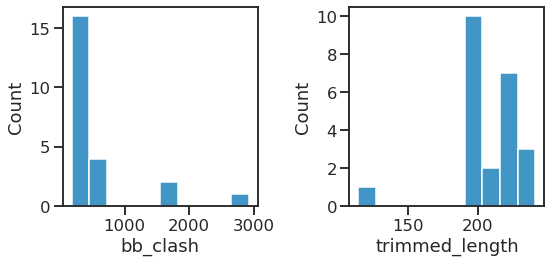

In [11]:
failed = pd.concat(failed_states)
from crispy_shifty.plotting.utils import histplot_df, pairplot_df

failed["trimmed_length"] = failed.trimmed_length.astype(int)
histplot_df(df=failed, bins=10, cols=["bb_clash", "trimmed_length"])

<Figure size 576x576 with 0 Axes>

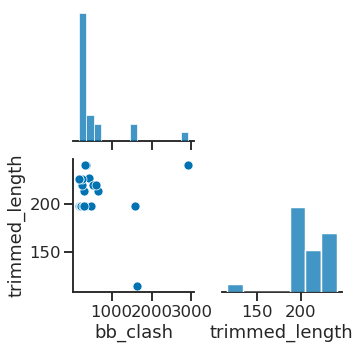

In [20]:
pairplot_df(df=failed, cols=["bb_clash", "trimmed_length"])

In [12]:
for f in list(inps.loc[inps["state"].str.contains("DHR4_p")].index):
    print(f"load {f} ;")
    # print(inps.loc[f].state)

load /mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0001/notebooks_02_make_bound_states_bd344c43c3524ca5a48b9c80a334e39f.pdb.bz2 ;
load /mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0001/notebooks_02_make_bound_states_891b5bfa0db84a8c862fceb688fa09a7.pdb.bz2 ;
load /mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0001/notebooks_02_make_bound_states_c518ba085ec746cca6bb8fd18da4ef37.pdb.bz2 ;
load /mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0001/notebooks_02_make_bound_states_5bfc2f748d5f4b559aef8b0f6f4301c3.pdb.bz2 ;
load /mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0001/notebooks_02_make_bound_states_fa6d2509483d42a78f0475c541f94496.pdb.bz2 ;
load /mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0001/notebooks_02_make_bound_states_f8723aa181af4788a95dfc95680902db.pdb.bz2 ;
load /mnt/home/pleung/projec

In [13]:
len(failed)

23

2it [00:00, 37.28it/s]


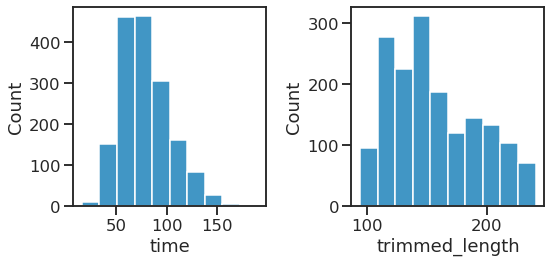

In [18]:
from crispy_shifty.plotting.utils import histplot_df, pairplot_df

histplot_df(df=scores_df, bins=10, cols=["time", "trimmed_length"])

<Figure size 576x576 with 0 Axes>

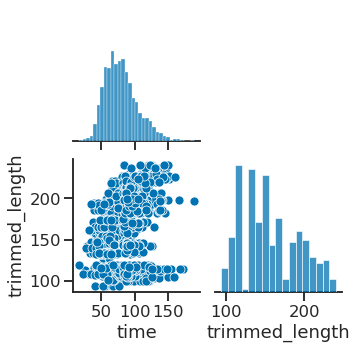

In [19]:
pairplot_df(df=scores_df, cols=["time", "trimmed_length"])

<Figure size 576x576 with 0 Axes>

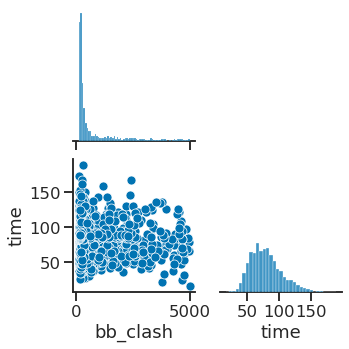

In [22]:
pairplot_df(df=scores_df, cols=["bb_clash", "time"])

In [25]:
len(inps[inps["bb_clash"] < 1000])

1381

### TODO Save a list of outputs

In [26]:
simulation_name = "00_design_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "designed_states.list"), "w") as f:
    for path in tqdm(scores_df.index):
        print(path, file=f)

  0%|          | 0/1670 [00:00<?, ?it/s]

### Prototyping blocks
`"-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",` isn't needed.  
`-precompute_ig true \-precompute_ig true \`
`-indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5 \`

In [6]:
%%time 
import pyrosetta

pyrosetta.init(
    "-corrections::beta_nov16"
)


sys.path.insert(0, "~/projects/crispy_shifty/") # TODO projects
from crispy_shifty.protocols.design import one_state_design_bound_state

t = one_state_design_bound_state(
        None,
        **{
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0000/notebooks_02_make_bound_states_6f2b82a6c1404a7389d1fe5797fb9176.pdb.bz2',
        }
)

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.44+release.de9edbfaf502e0b00debd50df9e9c36eb454838a 2021-11-02T20:42:19] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release r301 2021.44+release.de9edbf de9edbfaf502e0b00debd50df9e9c36eb454838a http://www.pyrosetta.org 2021-11-02T20:42:19
core.init: command: PyRosetta -corrections::beta_nov16 -database /projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=979037875 seed_offset=0 real_seed=979037875 thread_index=0
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=979037875 RG_type=mt19937
CP

In [ ]:
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

0.00 min: Generated interface selector
core.select.residue_selector.LayerSelector: Setting LayerSelector to use sidechain neighbors to determine burial.
core.select.residue_selector.LayerSelector: Set cutoffs for core and surface to 5.2 and 2, respectively, in LayerSelector.
core.select.residue_selector.LayerSelector: Setting core=true boundary=false surface=false in LayerSelector.
core.select.residue_selector.LayerSelector: Setting LayerSelector to use sidechain neighbors to determine burial.
core.select.residue_selector.LayerSelector: Setting LayerSelector to use sidechain neighbors to determine burial.
core.select.residue_selector.LayerSelector: Set cutoffs for core and surface to 5.2 and 2, respectively, in LayerSelector.
core.select.residue_selector.LayerSelector: Setting core=false boundary=true surface=false in LayerSelector.
core.select.residue_selector.LayerSelector: Setting LayerSelector to use sidechain neighbors to determine burial.
core.select.residue_selector.LayerSelecto

test crispy shifty array task utils

In [9]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "test"
design_list_file = os.path.join(
    os.getcwd(), "scaffolds/02_make_bound_states/bound_states.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        # "indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.utils.io.test_func",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="4G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/run.sh


In [10]:
!sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/run.sh

Submitted batch job 809877


In [16]:
from crispy_shifty.utils.io import test_func, wrapper_for_array_tasks


usage: ipykernel_launcher.py [-h] -pdb_path [PDB_PATH [PDB_PATH ...]]
                             [-options [OPTIONS [OPTIONS ...]]]
                             [-extra_options [EXTRA_OPTIONS [EXTRA_OPTIONS ...]]]
                             [-extra_kwargs [EXTRA_KWARGS [EXTRA_KWARGS ...]]]
                             -instance [INSTANCE [INSTANCE ...]]
ipykernel_launcher.py: error: the following arguments are required: -pdb_path, -instance


SystemExit: 2